### Fig +/- annealing step
- Show results of removing the annealing step on three individual primers

In [1]:
#Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import os
import gffutils
import seaborn as sns
import numpy as np
import scipy.stats as stats

sys.path.append('../scripts/')
from plot_helpers import *
import analyze_qpcr_plate

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Make outdir and load the data
outdir = '../figures/FS3/'
os.makedirs(outdir, exist_ok = True)

In [3]:
#Get the +/- annealing experiment data
qpcr_dir = os.path.join(results_dir, 'qPCR_data')

#annealing test data
data = ['190828_anneal_test/20190828_161126_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx', 
              '200710_retest_100ng_2/20200710_153721_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx',
              '200713_yeast_anneal3/20200713_134113_CT003077__QPCRBIOSMALQuantificationPlateViewResults.xlsx']

templates  = ['190828_anneal_test/qPCR_analysis_template_rep2_anneal.xlsx',
                    '200710_retest_100ng_2/qPCR_analysis_template_retest2_100ng.xlsx',
                    '200713_yeast_anneal3/qPCR_analysis_template_yeast_anneal3.xlsx']

exps = {'data': [os.path.join(qpcr_dir, i) for i in data],
       'templates': [os.path.join(qpcr_dir, i) for i in templates]}

df_list = []
for i in range(0, len(exps['data'])):
    df_list.append(analyze_qpcr_plate.main(exps['data'][i], exps['templates'][i], 'act5c'))
df = pd.concat(df_list)

In [4]:
#Get the anneal test samples off the plates
anneal_df = df.loc[df.index.get_level_values('sample').map(lambda x: x.startswith('B'))].copy()
anneal_df['percent_remaining'] = anneal_df['fold_change']*100
anneal_df['probe'], anneal_df['experiment'] = zip(*anneal_df.index.get_level_values('sample').map(lambda x: x.split('_')))
anneal_df.replace({'experiment': {'direct': 'no anneal'}}, inplace = True)

In [5]:
#Calculate the p-value for comparison of anneal to no anneal
#Better to test the ddCt values because the fold changes have been exponentiated
anneal_ddCt_means = anneal_df[anneal_df['experiment'] == 'anneal'].groupby('probe')['ddCt'].mean().values
noanneal_ddCt_means = anneal_df[anneal_df['experiment'] == 'no anneal'].groupby('probe')['ddCt'].mean().values

#anneal about 90% of noanneal. Therefore 10% decrease with the annealing step.
print('anneal/no anneal', 2**-(anneal_ddCt_means - noanneal_ddCt_means).mean())

#can do a paired t-test because we are testing the same probe +/- annealing
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
tmean, pmean = stats.ttest_rel(anneal_ddCt_means, noanneal_ddCt_means)

print('tmean', tmean)
print('pmean', pmean)

anneal/no anneal 0.8985444495952906
tmean 5.118903802702558
pmean 0.03610892671109859


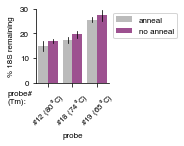

In [6]:
#Plot the depletion +/- the denaturation step
panel_name = 'S3A'
plot = Plotter(corners = [0.16, 0.33, 0.41, 0.62], figsize = (sfig*1.5, sfig))
plot.setup_axis()
plot.ax = sns.barplot(x="probe", y="percent_remaining", hue = 'experiment', data = anneal_df.reset_index(), 
                      ci = 'sd', errwidth = 0.75, ax = plot.ax)
plot.set_ylabel('% 18S remaining')
plot.ax.set_xticklabels([r'#12 (80$\degree$C)', '#18 (74$\degree$C)', '#19 (65$\degree$C)'], rotation = 45)
plot.ax.set_ylim(0, 30)
plt.legend(bbox_to_anchor = (1, 1), ncol = 1, fontsize = label_fontsize)
plot.ax.text(0.0, 0.16, 'probe#\n(Tm):', ha = 'left', transform = plot.fig.transFigure, fontsize = label_fontsize)
lines = plot.ax.lines
for line in lines:
    line.set_linewidth(0.75)
    line.set_color('k')
plt.savefig(os.path.join(outdir, '{}.{}'.format(panel_name, outfmt)), dpi = 600)